In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Please create your own copy before making changes.**

# **Code to convert German language to English!**

In [ ]:
import string
import re
from pickle import load,dump

from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
# load dataset
filename = '/content/drive/MyDrive/ml_folder/deu-eng/german_to_english_converter.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german.pkl
Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(lines):
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model


# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

English Vocabulary Size: 2171
English Max Length: 5
German Vocabulary Size: 3533
German Max Length: 9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 256)            904448    
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 2171)          557947    
 ibuted)                                                         
                    

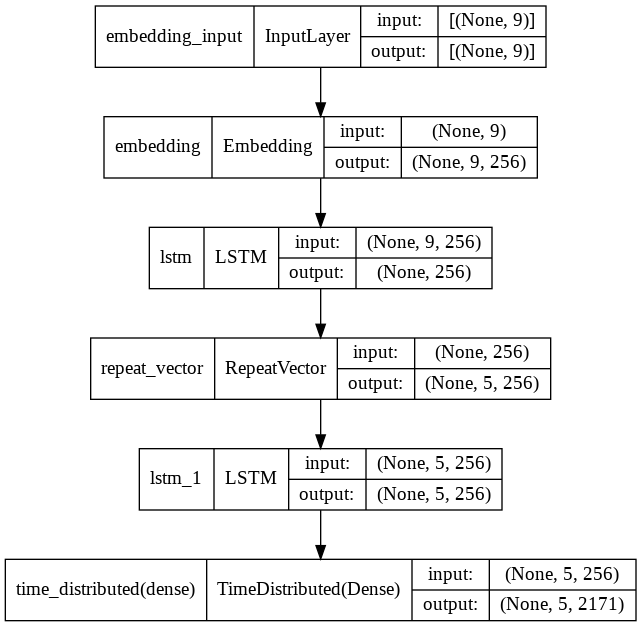

In [ ]:

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 3.31174, saving model to model.h5
141/141 - 33s - loss: 4.1168 - val_loss: 3.3117 - 33s/epoch - 234ms/step
Epoch 2/10

Epoch 00002: val_loss improved from 3.31174 to 3.17631, saving model to model.h5
141/141 - 24s - loss: 3.2063 - val_loss: 3.1763 - 24s/epoch - 172ms/step
Epoch 3/10

Epoch 00003: val_loss improved from 3.17631 to 3.08793, saving model to model.h5
141/141 - 24s - loss: 3.0647 - val_loss: 3.0879 - 24s/epoch - 171ms/step
Epoch 4/10

Epoch 00004: val_loss improved from 3.08793 to 2.96623, saving model to model.h5
141/141 - 24s - loss: 2.9200 - val_loss: 2.9662 - 24s/epoch - 171ms/step
Epoch 5/10

Epoch 00005: val_loss improved from 2.96623 to 2.84741, saving model to model.h5
141/141 - 24s - loss: 2.7782 - val_loss: 2.8474 - 24s/epoch - 172ms/step
Epoch 6/10

Epoch 00006: val_loss improved from 2.84741 to 2.72107, saving model to model.h5
141/141 - 24s - loss: 2.6170 - val_loss: 2.7211 - 24s/epoch - 172ms/step
Epoch 7/

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [ ]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[ich habe das gemacht], target=[i made that], predicted=[i saw it]
src=[es ist zu hause], target=[its at home], predicted=[its is]
src=[tom konnte mir bekannt sein], target=[i may know tom], predicted=[tom was a]
src=[mir gehts gut], target=[im ok], predicted=[im not]
src=[seid nicht unhoflich], target=[dont be rude], predicted=[dont be me]
src=[ich werde nicht tanzen], target=[i wont dance], predicted=[im not]
src=[ich habe ihn einmal getroffen], target=[i met him once], predicted=[i get you]
src=[tom braucht dich], target=[tom needs you], predicted=[tom is me]
src=[ich hasse euch alle], target=[i hate you all], predicted=[i like a]
src=[darf ich fragen warum], target=[can i ask why], predicted=[can i a you]


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.355230
BLEU-2: 0.192296
BLEU-3: 0.093750
BLEU-4: 0.134311
test
src=[das gesetz bin ich], target=[im the law], predicted=[im a]
src=[schlagt tom], target=[hit tom], predicted=[tom tom]
src=[schmeckts], target=[is it tasty], predicted=[go]
src=[ich habe sie gefunden], target=[i found you], predicted=[i was you]
src=[das gehort tom], target=[this is toms], predicted=[tom tom]
src=[tom mag es], target=[tom likes it], predicted=[tom was tom]
src=[es funktioniert gut], target=[it works well], predicted=[its is]
src=[du bist nicht ich], target=[you arent me], predicted=[who a you]
src=[es ist fruh], target=[its early], predicted=[its is]
src=[wer sah sie], target=[who saw you], predicted=[who you you]
BLEU-1: 0.326994
BLEU-2: 0.163522
BLEU-3: 0.066924
BLEU-4: 0.101653
